In [270]:
import pyro
import numpy as np
import scanpy as sc
import json
import pandas as pd
import os
import pyro.distributions as dist
import torch
from sklearn.neighbors import KernelDensity
import scipy
import utils
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
from collections import defaultdict
import os
import logging
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

In [266]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.0')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [272]:
adata = sc.read_h5ad("N_ribas310_clones.h5")

In [273]:
adata_subsampled, infer_subsampled = utils.format_data(adata, infer, 200, 200)

Trying to set attribute `.uns` of view, copying.


In [284]:
infer_subsampled

array([[1.00147243, 0.88779477, 0.88845267, ..., 1.12902298, 1.12408191,
        1.10662496],
       [1.00147243, 1.00147243, 1.00147243, ..., 1.00147243, 1.00147243,
        1.00147243],
       [1.00147243, 1.00147243, 1.00147243, ..., 1.00147243, 1.00147243,
        1.00147243],
       ...,
       [1.00100925, 1.00100925, 1.00100925, ..., 1.00100925, 1.00100925,
        1.00100925],
       [1.00100925, 1.00100925, 1.00100925, ..., 1.00100925, 1.00100925,
        1.00100925],
       [1.00100925, 1.00100925, 1.00100925, ..., 1.00100925, 1.00100925,
        1.00100925]])

In [285]:
mixture_mu=np.zeros(infer_subsampled.shape)
mu = [.9109, 1.001, 1.1167]
for i in range(infer_subsampled.shape[0]):
    for j in range(infer_subsampled.shape[1]):
        if infer_subsampled[i][j]<.95:
            mixture_mu[i][j]=mu[0]
        elif infer_subsampled[i][j]>.95 and infer_subsampled[i][j]<1.05:
            mixture_mu[i][j]=mu[1]
        else:
            mixture_mu[i][j]=mu[2]
            

In [315]:
adata_tensor=torch.tensor(adata_subsampled.X.astype("int"))

In [274]:
infer_sub_tensor = torch.tensor(infer_subsampled)

infer_sub_tensor_small = torch.flatten(infer_sub_tensor).to(torch.float)
infer_tensor_big =  torch.flatten(torch.tensor(infer.to_numpy())).to(torch.float)

data= infer_tensor_big[0:len(infer_tensor_big)//2]

In [275]:
K = 3  # Fixed number of components.

@config_enumerate
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))
        scale = pyro.sample('scale', dist.LogNormal(0., 2.))

    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale[assignment]), obs=data)

In [276]:
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [277]:
def init_loc_fn(site):
    if site["name"] == "weights":
        # Initialize weights to uniform.
        return torch.ones(K) / K
    if site["name"] == "scale":
        sig = (data.var() / 2).sqrt()
        return torch.tensor([sig,sig,sig])
    if site["name"] == "locs":
        return torch.tensor([.9,1.01,1.2])
    raise ValueError(site["name"])
    
def initialize(seed):
    global global_guide, svi
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scale']),
                             init_loc_fn=init_loc_fn)
    svi = SVI(model, global_guide, optim, loss=elbo)
    return svi.loss(model, global_guide, data)

# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 0, initial_loss = -33554424.0


In [278]:
 # Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(200 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

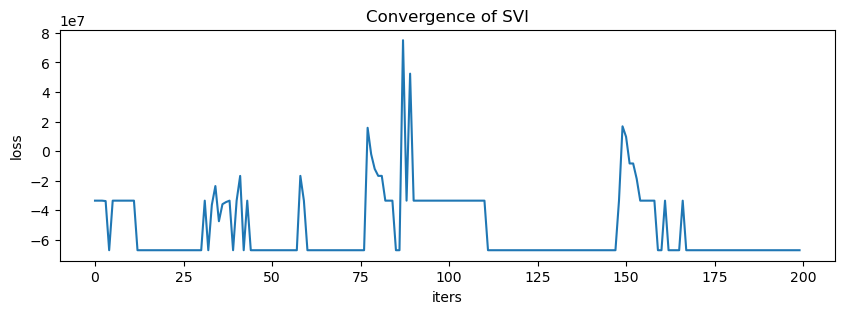

In [281]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.title('Convergence of SVI');

In [282]:
pyro.get_param_store().named_parameters()

dict_items([('AutoDelta.weights', Parameter containing:
tensor([ 2.3177, -2.0559, -2.0370], requires_grad=True)), ('AutoDelta.locs', Parameter containing:
tensor([1.0081, 0.4694, 0.9009], requires_grad=True)), ('AutoDelta.scale', Parameter containing:
tensor([-3.0749, -4.4049, -4.2369], requires_grad=True))])

In [283]:
for weight in [ 2.3177, -2.0559, -2.0370]:
    print(np.exp(weight))

10.152297149205193
0.1279776038875509
0.13041938272582848


In [245]:
data = []
for i in range(10):
    data.append(abs(np.random.normal(10,5,5)))

In [246]:
data=torch.tensor(np.asarray(data).astype("int"))

In [326]:
def model(data):
    mixture_mu=np.zeros(infer_subsampled.shape)
    mu = [.9109, 1.001, 1.1167]
    for i in range(infer_subsampled.shape[0]):
        for j in range(infer_subsampled.shape[1]):
            if infer_subsampled[i][j]<.95:
                mixture_mu[i][j]=mu[0]
            elif infer_subsampled[i][j]>.95 and infer_subsampled[i][j]<1.05:
                mixture_mu[i][j]=mu[1]
            else:
                mixture_mu[i][j]=mu[2]
    mixture_mu=torch.tensor(mixture_mu)
    a=1.0
    ap=1.0
    b=1.0
    #std_1 = torch.std(torch.sum(data, axis=1))
    bp = 1.0 #float(torch.mean(torch.sum(data,axis=1))/std_1)
    c=1.0
    C=data.shape[0]
    G=data.shape[1]
    eta_sigma=1
    with pyro.plate("xis", C):
        xi = pyro.sample("xi", dist.Gamma(torch.tensor(ap),torch.tensor(bp)))
        theta = pyro.sample("theta",dist.Gamma(a,xi))
    
    with pyro.plate("ets",G):
        with pyro.plate("betas",C):
            eta = pyro.sample("eta", dist.LogNormal(mixture_mu, eta_sigma))
            beta = pyro.sample("beta", dist.Gamma(c, eta))

    with pyro.plate("ets2",G):
        with pyro.plate("betas2",C):
            X = pyro.sample("X", dist.Poisson(torch.tensor(torch.tile(theta,(G,1)).T)*beta),obs=data) 
            
    return theta,beta


In [299]:
adata_tensor

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.4152],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0922, 0.0000, 0.0000,  ..., 0.0000, 0.5726, 0.0000],
        [0.5512, 0.0785, 0.5972,  ..., 0.0000, 0.6833, 0.8000],
        [0.0000, 0.1337, 0.0000,  ..., 0.0000, 0.2517, 0.0000]])

In [300]:
t,b=model(adata_tensor)

/Users/joyfan/miniconda3/envs/labenv/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [303]:
lambd = np.zeros(b.shape)
for i in range(lambd.shape[0]):
    for j in range(lambd.shape[1]):
        lambd[i][j] = t[i] * b[i][j]

In [305]:
posteriors_all = []
for k in range(1):
    posterior = np.zeros(lambd.shape)
    for i in range(lambd.shape[0]):
        for j in range(lambd.shape[1]):
            posterior[i][j] = np.random.poisson(lambd[i][j])
    posteriors_all.append(posterior)
posteriors_all[0]

array([[ 0.,  4.,  0., ...,  0., 12.,  0.],
       [ 2.,  0.,  0., ...,  0.,  0.,  1.],
       [ 3.,  0.,  1., ...,  0.,  0.,  1.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 4., 11.,  7., ...,  3.,  1., 19.],
       [ 0.,  1.,  3., ...,  0.,  0.,  0.]])

In [323]:
def guide(data):
    mixture_mu=np.zeros(infer_subsampled.shape)
    mu = [.9109, 1.001, 1.1167]
    for i in range(infer_subsampled.shape[0]):
        for j in range(infer_subsampled.shape[1]):
            if infer_subsampled[i][j]<.95:
                mixture_mu[i][j]=mu[0]
            elif infer_subsampled[i][j]>.95 and infer_subsampled[i][j]<1.05:
                mixture_mu[i][j]=mu[1]
            else:
                mixture_mu[i][j]=mu[2]
    mixture_mu=torch.tensor(mixture_mu)
    C=data.shape[0]
    G=data.shape[1]
    a_q = pyro.param("a_q",torch.tensor(1.0), constraint=dist.constraints.positive)
    ap_q = pyro.param("ap_q",torch.tensor(1.0), constraint=dist.constraints.positive)
    b_q = pyro.param("b_q",torch.tensor(1.0), constraint=dist.constraints.positive)
    bp_q = pyro.param("bp_q",torch.tensor(1.0), constraint=dist.constraints.positive)
    c_q = pyro.param("c_q",torch.tensor(1.0), constraint=dist.constraints.positive)
    eta_sig_q = pyro.param("eta_sig_q",torch.tensor(1.0), constraint=dist.constraints.positive)
    
    with pyro.plate("xis", C):
        xi = pyro.sample("xi",dist.Gamma(a_q,b_q))
        theta = pyro.sample("theta",dist.Gamma(a_q, xi))
    
    with pyro.plate("ets",G):
        with pyro.plate("betas",C):
            eta = pyro.sample("eta", dist.LogNormal(mixture_mu, eta_sig_q))
            beta = pyro.sample("beta", dist.Gamma(c_q, eta))
        
    with pyro.plate("ets2",G):
        with pyro.plate("betas2",C):
            pyro.sample("X",dist.Poisson(torch.tensor(torch.tile(theta,(G,1)).T)*beta))
            
    param_store = pyro.get_param_store()
    param_store.__setitem__('theta',theta)
    param_store.__setitem__('beta',beta)
    param_store.__setitem__('xi',xi)
    

In [324]:
import pyro
from pyro.infer import SVI, Trace_ELBO
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
from pyro.optim import Adam

In [344]:
# set up the optimizer
adam_params = {"lr": 0.5, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 100
losses = []
# do gradient steps
for step in range(n_steps):
    loss=svi.step(adata_tensor)
    losses.append(loss)

/Users/joyfan/miniconda3/envs/labenv/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/joyfan/miniconda3/envs/labenv/lib/python3.6/site-packages/pyro/util.py:291: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'X'}
  guide_vars - aux_vars - model_vars


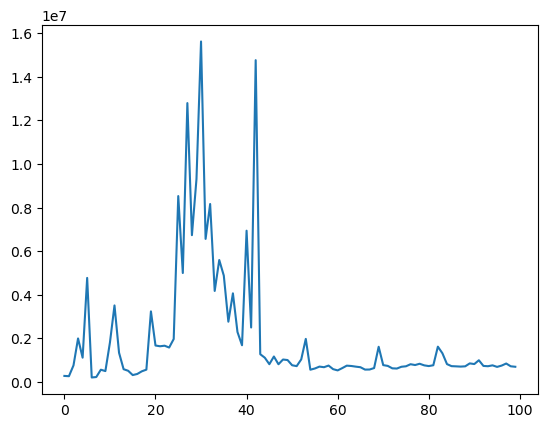

In [345]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses)),losses)

In [346]:
theta = dict(pyro.get_param_store().named_parameters())['theta']
beta = dict(pyro.get_param_store().named_parameters())['beta']

In [347]:
lambd = np.zeros(beta.shape)
for i in range(lambd.shape[0]):
    for j in range(lambd.shape[1]):
        lambd[i][j] = theta[i] * beta[i][j]

In [348]:
posteriors_all = []
for k in range(1000):
    posterior = np.zeros(lambd.shape)
    for i in range(lambd.shape[0]):
        for j in range(lambd.shape[1]):
            posterior[i][j] = np.random.poisson(lambd[i][j])
    posteriors_all.append(posterior)

/Users/joyfan/miniconda3/envs/labenv/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/Users/joyfan/miniconda3/envs/labenv/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/Users/joyfan/miniconda3/envs/labenv/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/Users/joyfan/miniconda3/envs/labenv/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


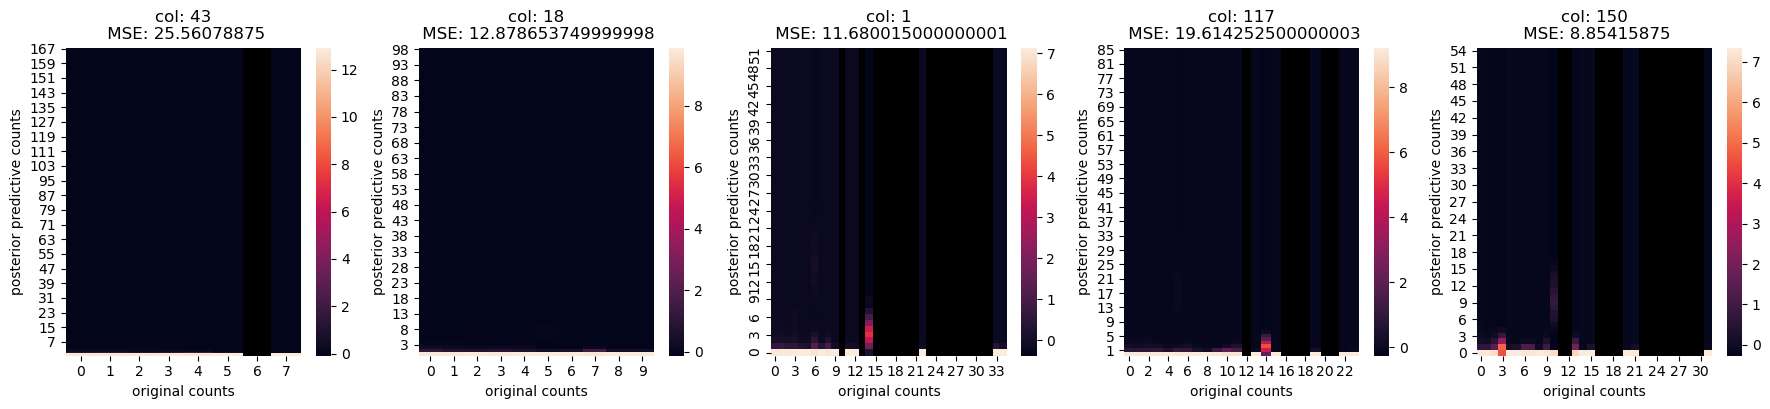

In [349]:
posteriors_all = np.asarray(posteriors_all)
fig, ax = plt.subplots(1, 5, figsize=(22, 4))
ind = 0
rands = np.random.choice([i for i in range(200)], size=5, replace=False)
for col in rands:
    combined_x = []
    combined_y = []
    heatmap = np.zeros((int(max(posteriors_all[:, :, col].flatten())) + 1,
                        int(max(adata_subsampled.layers['counts'][:, col]))
                        + 1))
    max_post = int(max(posteriors_all[:, :, col].flatten()))
    for i in range(1000):
        combined_x.append(adata_subsampled.layers['counts'][:, col])
        combined_y.append(posteriors_all[i][:, col])
        for j in range(800):
            tmp_coord = int(adata_subsampled.layers['counts'][j, col])
            heatmap[max_post -
                    int(posteriors_all[i, j, col])][tmp_coord] += 1
    MSE = sklearn.metrics.mean_squared_error(combined_x, combined_y)
    hmap = pd.DataFrame(scipy.stats.zscore(heatmap))
    hmap.columns = [i for i in range(heatmap.shape[1])]
    hmap.index = np.flip([i for i in range(heatmap.shape[0])])
    g = sns.heatmap(hmap, ax=ax[ind])
    g.set_facecolor('black')
    g.set_xlabel("original counts")
    g.set_ylabel("posterior predictive counts")
    g.set_title("col: " + str(col) + "\n MSE: " + str(MSE))
    ind += 1